In [1]:
import torch
import math

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

torch.manual_seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class AttentionHead(nn.Module):

    def __init__(self, emb_dim, head_size, context_window_len, mask):
        super(AttentionHead, self).__init__()
        # These Layers Map (B, W, E) -> (B, W, HEAD_SIZE)

        assert mask == 'encoder' or mask == 'decoder'

        self.key = nn.Linear(emb_dim, head_size, bias=False, device=device)
        self.query = nn.Linear(emb_dim, head_size, bias=False, device=device)
        self.value = nn.Linear(emb_dim, head_size, bias=False, device=device)
        self.mask_type = mask
        self.context_window_len = context_window_len
        self.head_size = head_size

    # Returns a mask of (W, W)
    def get_mask_tensor(self):
        if (self.mask_type == 'encoder'):
            return torch.tril(torch.ones(self.context_window_len, self.context_window_len, device=device))
        elif (self.mask_type == 'decoder'):
            return torch.ones(self.context_window_len, self.context_window_len, device=device)
    
    # Input is of shape (B, W, E) where E is embedding dimensions.
    # Output is of shape (B, W, E)
    def forward(self, input):
        k = self.key(input) # Convert (B, W1, E) -> (B, W1, HEAD_SIZE)
        q = self.query(input) # Convert (B, W2, E) -> (B, W2, HEAD_SIZE) (W1 == W2 == W3)
        v = self.value(input) # (B, W3, E) -> (B, W3, HEAD_SIZE)
        match = q @ k.transpose(-2, -1) # Produce Matrix (B, W1, W2)
        mask = self.get_mask_tensor()
        match = match.masked_fill(mask == 0, float('-inf'))
        attention = torch.softmax(match, dim=-1) / math.sqrt(self.head_size) # Still (B, W1, W2)

        res = attention @ v # (B, W1, W2) @ (B, W3, HEAD_SIZE) -> (B, W1=W3, HEAD_SIZE)
        return res

In [3]:
class MultiHeadedAttention(nn.Module):

    def __init__(self, emb_dim, num_heads, context_window_len, mask):
        super(MultiHeadedAttention, self).__init__()
        assert emb_dim % num_heads == 0
        self.attention_heads = [AttentionHead(emb_dim, emb_dim // num_heads, context_window_len, mask) for i in range(0, num_heads)]
        

    # Input is (B, W, E)
    def forward(self, input):
        # Each ah returns (B, W, E/num_heads)
        return torch.cat([ah(input) for ah in self.attention_heads], dim= -1)


In [4]:
class Block(nn.Module):
    def __init__(self, context_window_size, embedding_dimensions, num_heads, hidden_layer_multiplier = 4, dropout_rate = 0.3):
        super(Block, self).__init__()

        self.network = nn.Sequential(
            MultiHeadedAttention(embedding_dimensions, num_heads, context_window_size, 'encoder'),
            nn.Linear(embedding_dimensions, hidden_layer_multiplier * embedding_dimensions, device=device),
            nn.ReLU(),
            nn.Linear(embedding_dimensions * hidden_layer_multiplier, embedding_dimensions, device=device),
            nn.LayerNorm(embedding_dimensions, device=device),
            nn.Dropout(dropout_rate)
        )

    # Raw input is a tesnor of (B, W). It should have already mapped tokens to integer.
    def forward(self, raw_input):
        return self.network(raw_input)

class CustomTransformer(nn.Module):

    # Input to the Transformer will be a matrix of size (B, W)
    # B is the Batch Size.
    # W is the Window Size (context_window_size)
    # Example:
    # [a, b, c]
    # [d, e, f]
    #
    # [a, b, c] is an input example. (context_len = W = 3)
    # There are two batches [a, b, c] and [d, e, f] (B = 2)
    # a, b, c should be integers (each representing one possible token). a, b, c should belong in [0, dict_size)
    def __init__(self, dict_size, context_window_size, embedding_dimensions, num_heads, block_count):
        super(CustomTransformer, self).__init__()
        self.context_window_size = context_window_size
        self.token_embedding = nn.Embedding(dict_size, embedding_dimensions, device=device)
        self.position_embedding = nn.Embedding(context_window_size, embedding_dimensions, device=device)
        self.decoder = nn.Linear(embedding_dimensions, dict_size, device=device)

        self.network = nn.Sequential(
            *[Block(context_window_size, embedding_dimensions, num_heads) for _ in range(0, block_count)]
        )

    def embed(self, input, spatial = False):
        emb = self.token_embedding(input)
        if (spatial):
            return emb + self.position_embedding(torch.arange(0, self.context_window_size, device=device))

        return emb

    # Raw input is a tesnor of (B, W). On CPU. It should have already mapped tokens to integer.
    def forward(self, raw_input, targets):
        if(raw_input.device != device):
            raw_input = raw_input.to(device)
        input = self.embed(raw_input, True)
        logits = self.network(input)
        logits = self.decoder(logits)
        if (targets != None):
            if(targets.device != device):
                targets = targets.to(device)
            logits_1d = logits.view(logits.shape[0] * logits.shape[1], logits.shape[2])
            targets = targets.view(logits_1d.shape[0])
            loss = F.cross_entropy(logits_1d, targets)
        else:
            loss = None
        return logits, loss

In [5]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, context_len):
        self.data = data
        self.context_len = context_len

    # ABCDE for context len of 1 has 4 examples: (A, B), (B, C), (C, D), (D, E)
    # for context len 2 has examples 3 (AB, C), (BC, D), (CD, E)
    def __len__(self):
        return len(self.data) - self.context_len

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx : idx + self.context_len], device = device), torch.tensor(self.data[idx + 1 :idx + self.context_len + 1], device=device)

In [1]:
DELIMITER = ""

In [2]:
import coDesc_parser

res = coDesc_parser.fragment_dataset("../data/CoDesc/CoDesc.json", "../data/CoDesc/fragmented", limit=100)
print(res)
#coDesc_parser.fragmented_files_to_txt_file(range(90), "../data/CoDesc/fragmented", DELIMITER, "train.txt")
#coDesc_parser.fragmented_files_to_txt_file(range(90, 100), "../data/CoDesc/fragmented", DELIMITER, "test.txt")

subfolder_0/example_0.json
1
subfolder_0/example_1.json
2
subfolder_0/example_2.json
3
subfolder_0/example_3.json
4
subfolder_0/example_4.json
5
subfolder_0/example_5.json
6
subfolder_0/example_6.json
7
subfolder_0/example_7.json
8
subfolder_0/example_8.json
9
subfolder_0/example_9.json
10
subfolder_0/example_10.json
11
subfolder_0/example_11.json
12
subfolder_0/example_12.json
13
subfolder_0/example_13.json
14
subfolder_0/example_14.json
15
subfolder_0/example_15.json
16
subfolder_0/example_16.json
17
subfolder_0/example_17.json
18
subfolder_0/example_18.json
19
subfolder_0/example_19.json
20
subfolder_0/example_20.json
21
subfolder_0/example_21.json
22
subfolder_0/example_22.json
23
subfolder_0/example_23.json
24
subfolder_0/example_24.json
25
subfolder_0/example_25.json
26
subfolder_0/example_26.json
27
subfolder_0/example_27.json
28
subfolder_0/example_28.json
29
subfolder_0/example_29.json
30
subfolder_0/example_30.json
31
subfolder_0/example_31.json
32
subfolder_0/example_32.json

In [ ]:
from tiktoken._educational import *

tokenizer = tiktoken.get_encoding("cl100k_base")

with open("../data/CoDesc/fragmented/train.txt", "r") as f:
    train = f.read()

with open("../data/CoDesc/fragmented/test.txt", "r") as f:
    test = f.read()

train_enc = tokenizer.encode(train)
test_enc = tokenizer.encode(test)

FileNotFoundError: [Errno 2] No such file or directory: '../data/CoDesc/fragmented/train.txt'

In [ ]:
CONTEXT_LEN = 512
BLOCK_COUNT = 2
EMBED_DIM = 256
NUM_HEADS = 8
LEARNING_RATE = 1e-2
BATCH_COUNT = 8
ITERATIONS = 2

In [ ]:
transformer = CustomTransformer(tokenizer.n_vocab, CONTEXT_LEN, EMBED_DIM, NUM_HEADS, BLOCK_COUNT)
optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

print(sum(p.numel() for p in transformer.parameters()))

52625333


In [ ]:
def complete(ctx, new_len):
    res = [x for x in ctx]
    
    for _ in range(new_len):
        ctx = torch.tensor([res[-CONTEXT_LEN:]])
        prob, loss = transformer(ctx, None) # Returns a tensor of size (1, W, EM)
        prob = prob.squeeze(0)
        prob = torch.softmax(prob, dim=-1) # (1, W, EM)
        pred = torch.multinomial(prob, 1) # (1, W, 1)
        res.append(pred[-1, 0].item())
    return tokenizer.decode(res[-new_len:])

In [ ]:
loss_history = []
history = []
loss_avg_block_size = 2

train_dataset = TextDataset(train_enc, CONTEXT_LEN)
train_loader = DataLoader(train_dataset, BATCH_COUNT, shuffle=True)
# Prefetch the first batch
#train_in, train_target = get_batches(train_enc, BATCH_COUNT, CONTEXT_LEN)

i = 0
for current_train_in, current_train_target in train_loader:
    # Process the current batch
    logits, loss = transformer(current_train_in, current_train_target)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    history.append(loss.item())
    if (len(history) >= loss_avg_block_size):
        loss_history.append(torch.tensor(history).mean().item())
        history = []
        print (f"Iteration {i} Loss: {loss_history[-1]}")
    i += 1

    if (i >= ITERATIONS):
        break

if (len(history) > 0):
    loss_history.append(torch.tensor(history).mean().item())

Iteration 1 Loss: 11.547046661376953


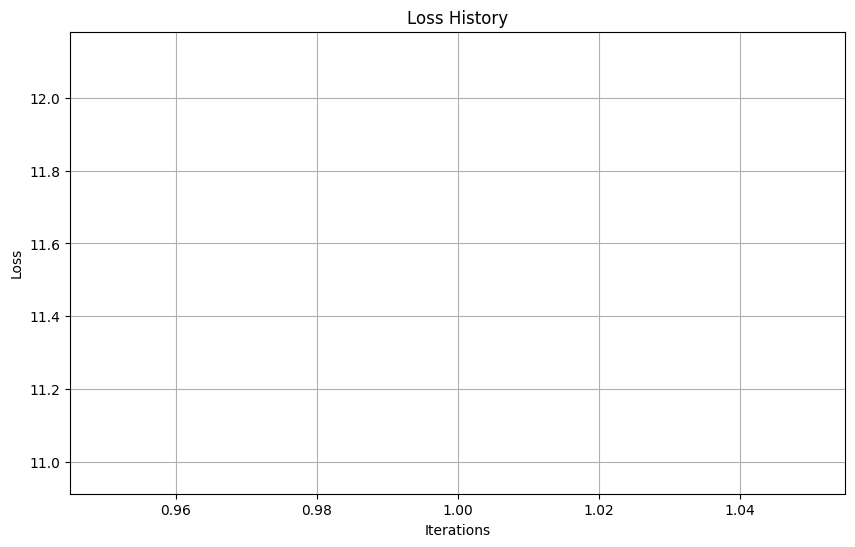

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history * loss_avg_block_size) + 1, loss_avg_block_size), loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.grid(True)
plt.show()


In [ ]:
start = torch.randint(0, len(test_enc) - CONTEXT_LEN, (1,)).item()
sampled_txt = test_enc[start:start+CONTEXT_LEN]
print("_________________________SAMPLED_________________________:")
print(tokenizer.decode(sampled_txt))
print("_________________________PREDICTED_______________________:")
print(complete(sampled_txt, 16))

_________________________SAMPLED_________________________:
 directExecutor() cannot throw RejectedExecutionException
      return delegate;
    }
    return new Executor() {
      boolean thrownFromDelegate = true;

      @Override
      public void execute(final Runnable command) {
        try {
          delegate.execute(
              new Runnable() {
                @Override
                public void run() {
                  thrownFromDelegate = false;
                  command.run();
                }
              });
        } catch (RejectedExecutionException e) {
          if (thrownFromDelegate) {
            // wrap exception?
            future.setException(e);
          }
          // otherwise it must have been thrown from a transitive call and the delegate runnable
          // should have handled it.
        }
      }
    };
  }
public Writer openBufferedStream() throws IOException {
    Writer writer = openStream();
    return (writer instanceof BufferedWriter)
   